In [2]:
#make necessary imports:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import box

In [3]:
#define bounds for the lat and lon of manhattan:
manhattan_bounds = [-74.03, 40.70, -73.93, 40.88]  # (min_lon, min_lat, max_lon, max_lat)

In [4]:
#get a geoDataFrame for the data and view it
manhattan_gdf = gpd.GeoDataFrame(
    {"geometry": [box(*manhattan_bounds)]}, 
    crs="EPSG:4326"  # Latitude/Longitude Coordinate System
)


manhattan_gdf = manhattan_gdf.to_crs(epsg=4326)


In [5]:
#checking for available tile providers
print(ctx.providers.keys())

dict_keys(['OpenStreetMap', 'MapTilesAPI', 'OpenSeaMap', 'OPNVKarte', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Stadia', 'Thunderforest', 'BaseMapDE', 'CyclOSM', 'Jawg', 'MapBox', 'MapTiler', 'TomTom', 'Esri', 'OpenWeatherMap', 'HERE', 'HEREv3', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'GeoportailFrance', 'OneMapSG', 'USGS', 'WaymarkedTrails', 'OpenAIP', 'OpenSnowMap', 'AzureMaps', 'SwissFederalGeoportal', 'TopPlusOpen', 'Gaode', 'Strava', 'OrdnanceSurvey'])


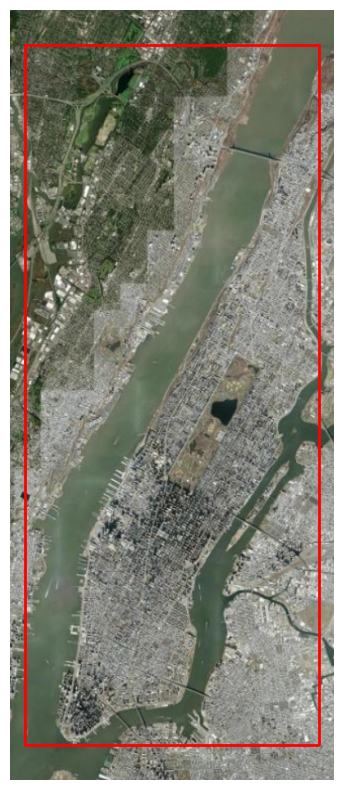

In [16]:
# Plot with correct projection
fig, ax = plt.subplots(figsize=(10, 10))
manhattan_gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

# Add basemap with the correct CRS
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=manhattan_gdf.crs, attribution=False)

# Label axes with lat/lon
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

#save this image of manhattan for further anlysis:
plt.axis("off")
plt.savefig("manhattan_map.png", dpi=300, bbox_inches='tight')

plt.show() #just the plot should have the lat and lon values

xlim = ax.get_xlim()  # (min_lon, max_lon)
ylim = ax.get_ylim()  # (min_lat, max_lat)


In [17]:
import pandas as pd
import numpy as np

#now limit the training data to only what fits in the bounds of manhattan so I can train the model on the images, an using image analysis
trainData = pd.read_csv('trainingUHI_Data.csv')

manTrainData = trainData[(trainData['Latitude'] >= manhattan_bounds[1]) & 
                 (trainData['Latitude'] <= manhattan_bounds[3]) & 
                 (trainData['Longitude'] >= manhattan_bounds[0]) & 
                 (trainData['Longitude'] <= manhattan_bounds[2])]

print(trainData.shape)
print(manTrainData.shape)

print('Manhattan bounds:',manhattan_bounds)

print('Min/max lats')
print(min(manTrainData['Latitude']),max(manTrainData['Latitude']))

print('Min/max lons')
print(min(manTrainData['Longitude']),max(manTrainData['Longitude']))

#manTrainData.to_csv('manTrainData')

(11229, 4)
(5963, 4)
Manhattan bounds: [-74.03, 40.7, -73.93, 40.88]
Min/max lats
40.75879167 40.85949667
Min/max lons
-73.99445667 -73.93000667


In [18]:
manTrainData.to_csv('manTrainData')

In [19]:
import matplotlib.image as mpimg

# Load the image into an array
image_array = mpimg.imread("manhattan_map.png")




(2370, 1031, 4)


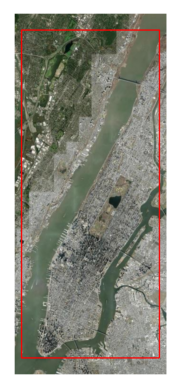

In [20]:
# Print the shape of the array
print(image_array.shape)  # (Height, Width, Channels)

# Display the array as an image
plt.imshow(image_array)
plt.axis("off")
plt.show()

In [21]:
import numpy as np
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim

In [22]:
#first lets try matrix completion

#build a function to translate pixel values into lat and lons
img_height, img_width = image_array.shape[:2]  # Only take height & width
img_height,img_width


(2370, 1031)

In [23]:
#only take the pixels that align with the manTrainData coordinates
def latlon_to_pixel(lon, lat, xlim, ylim, img_width, img_height):
    """
    Convert latitude and longitude to pixel coordinates (px, py).
    """
    px = int((lon - xlim[0]) / (xlim[1] - xlim[0]) * img_width)
    py = int((ylim[1] - lat) / (ylim[1] - ylim[0]) * img_height)  # Flip y-axis

    return px, py

def pixel_to_latlon(px, py, xlim, ylim, img_width, img_height):
    """
    Convert pixel coordinates (px, py) to latitude and longitude.
    """
    lon = xlim[0] + (px / img_width) * (xlim[1] - xlim[0])
    lat = ylim[1] - (py / img_height) * (ylim[1] - ylim[0])  # Flip y-axis

    return lon, lat

In [ ]:
# Convert lat/lon to pixel coordinates for all rows
manTrainData["Pixel_X"], manTrainData["Pixel_Y"] = zip(*manTrainData.apply(lambda row: latlon_to_pixel(
    row["Longitude"], row["Latitude"], xlim, ylim, img_width, img_height), axis=1))

# Convert to a list of (x, y) pixel pairs
pixel_pairs = list(zip(manTrainData["Pixel_X"], manTrainData["Pixel_Y"]))


5963


/tmp/ipykernel_242639/1631734623.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manTrainData["Pixel_X"], manTrainData["Pixel_Y"] = zip(*manTrainData.apply(lambda row: latlon_to_pixel(


In [67]:
#now that I have pixel pairs, I want to translate them, feed them into a NN and let it do its thing

#make a list of latitudes and longitudes
latsAndlons = list(zip(manTrainData['Latitude'],manTrainData['Longitude']))

#define your NN
import numpy as np
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim

class LearnInputsLayers(nn.Module):
    def __init__(self):
        super(LearnInputsLayers, self).__init__()
        self.hidden_layer = nn.Linear(4, 5) #take in 4 values, which is the RGBA data, output 5?
        self.activation = nn.ReLU()
        self.next_layer = nn.Linear(5, 7)
        self.output_layer = nn.Linear(7, 1) #take in 3 after activation, output 1
        #no activation after output layer

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.activation(x)
        x = self.next_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        # no activation after output layer
        return x
    
nn_model1 = LearnInputsLayers() 

In [ ]:

#lil = LearnInputsLayers()

criterion=nn.MSELoss()
#optimizer=optim.SGD(lil.parameters(),lr=0.01)

In [46]:
rgb_values = [image_array[y, x] for x, y in pixel_pairs]
uhi_List = np.array(manTrainData['UHI Index'])

In [47]:



rgbs = np.array(rgb_values)
#print(rgb_values)
data = torch.tensor(rgbs.reshape(-1,4), dtype=torch.float32)
targets =torch.tensor(uhi_List.reshape(-1,1),dtype=torch.float32)
data


tensor([[0.6000, 0.6000, 0.5647, 1.0000],
        [0.6196, 0.6235, 0.5843, 1.0000],
        [0.6392, 0.6471, 0.6039, 1.0000],
        ...,
        [0.4980, 0.4902, 0.3961, 1.0000],
        [0.4980, 0.4902, 0.3961, 1.0000],
        [0.4941, 0.4863, 0.3961, 1.0000]])

In [68]:
optimizer =optim.SGD(nn_model1.parameters(),lr=0.1)
#train nn_model

EPOCHS=1000

for epoch in range(EPOCHS):
        
    preds=nn_model1(data)
    loss=criterion(preds, targets)
    


    optimizer.zero_grad()
    loss.backward()

    #for param in nn_model.parameters():
    #    print(param.grad)

    optimizer.step()
    
    if epoch%100==0:
        print(f'epoch: {epoch} loss: {loss.item():.4f}')
        

epoch: 0 loss: 0.7726
epoch: 100 loss: 0.0003
epoch: 200 loss: 0.0003
epoch: 300 loss: 0.0003
epoch: 400 loss: 0.0003
epoch: 500 loss: 0.0003
epoch: 600 loss: 0.0003
epoch: 700 loss: 0.0003
epoch: 800 loss: 0.0003
epoch: 900 loss: 0.0003


In [76]:
#check the model for effectiveness on Bronx data points
#get bronx data points: rest of the traininUHIData
bronxTrainData = trainData[~trainData.isin(manTrainData.to_dict(orient='list')).all(axis=1)]
bronx_bounds = [min(bronxTrainData['Longitude']), min(bronxTrainData['Latitude']), max(bronxTrainData['Longitude']),max(bronxTrainData['Latitude'])]


# get image and other stuff
#get a geoDataFrame for the data and view it
bronx_gdf = gpd.GeoDataFrame(
    {"geometry": [box(*bronx_bounds)]}, 
    crs="EPSG:4326"  # Latitude/Longitude Coordinate System
)


bronx_gdf = bronx_gdf.to_crs(epsg=4326)


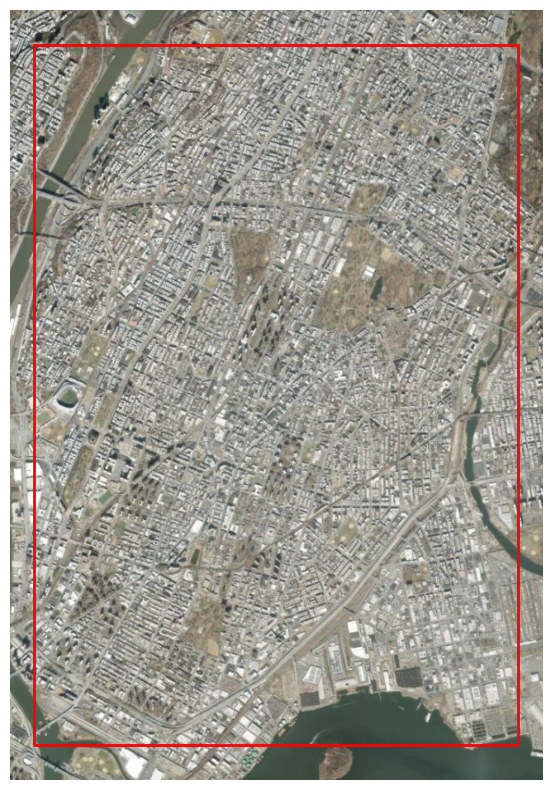

In [90]:
# Plot with correct projection
figB, axB = plt.subplots(figsize=(10, 10))
bronx_gdf.plot(ax=axB, facecolor="none", edgecolor="red", linewidth=2)

# Add basemap with the correct CRS
ctx.add_basemap(axB, source=ctx.providers.Esri.WorldImagery, crs=bronx_gdf.crs, attribution=False)

# Label axes with lat/lon
axB.set_xlabel("Longitude")
axB.set_ylabel("Latitude")

#save this image of bronx for further anlysis:
plt.axis("off")
plt.savefig("bronx_map.png", dpi=300, bbox_inches='tight')

plt.show() #just the plot should have the lat and lon values

#xlimB = axB.get_xlim()  # (min_lon, max_lon)
#ylimB = axB.get_ylim()  # (min_lat, max_lat)

In [94]:
image_arrayB = mpimg.imread("bronx_map.png")
xlimB = axB.get_xlim()  # (min_lon, max_lon)
ylimB = axB.get_ylim()  # (min_lat, max_lat)

img_heightB, img_widthB = image_arrayB.shape[:2]


bronxTrainData["Pixel_X"], bronxTrainData["Pixel_Y"] = zip(*bronxTrainData.apply(lambda row: latlon_to_pixel(
    row["Longitude"], row["Latitude"], xlimB, ylimB, img_widthB, img_heightB), axis=1))

pixel_pairsB = list(zip(bronxTrainData["Pixel_X"], bronxTrainData["Pixel_Y"]))

rgb_valuesB = [image_arrayB[y, x] for x, y in pixel_pairsB]
uhi_ListB = np.array(bronxTrainData['UHI Index'])

/tmp/ipykernel_242639/2102008744.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bronxTrainData["Pixel_X"], bronxTrainData["Pixel_Y"] = zip(*bronxTrainData.apply(lambda row: latlon_to_pixel(


In [96]:
rgbsB = np.array(rgb_valuesB)
#print(rgb_values)
dataB = torch.tensor(rgbsB.reshape(-1,4), dtype=torch.float32)
targetsB =torch.tensor(uhi_ListB.reshape(-1,1),dtype=torch.float32)
len(dataB)
#len(targetsB)

5266

In [97]:

with torch.no_grad():  # Disable gradient computation for testing
    nn_model1.eval()  # Set the model to evaluation mode
    val_preds = nn_model1(dataB)  # Get predictions on the validation set
    val_loss = criterion(val_preds, targetsB)  # Calculate loss
    print(f'Validation Loss: {val_loss.item():.4f}')

Validation Loss: 0.0003


In [99]:
optimizer =optim.SGD(nn_model1.parameters(),lr=0.01)
#train nn_model

EPOCHS=20000

for epoch in range(EPOCHS):
        
    preds=nn_model1(dataB)
    loss=criterion(preds, targetsB)
    


    optimizer.zero_grad()
    loss.backward()

    #for param in nn_model.parameters():
    #    print(param.grad)

    optimizer.step()
    
    if epoch%1000==0:
        print(f'epoch: {epoch} loss: {loss.item():.4f}')

epoch: 0 loss: 0.0002
epoch: 1000 loss: 0.0002
epoch: 2000 loss: 0.0002
epoch: 3000 loss: 0.0002
epoch: 4000 loss: 0.0002
epoch: 5000 loss: 0.0002
epoch: 6000 loss: 0.0002
epoch: 7000 loss: 0.0002
epoch: 8000 loss: 0.0002
epoch: 9000 loss: 0.0002
epoch: 10000 loss: 0.0002
epoch: 11000 loss: 0.0002
epoch: 12000 loss: 0.0002
epoch: 13000 loss: 0.0002
epoch: 14000 loss: 0.0002
epoch: 15000 loss: 0.0002
epoch: 16000 loss: 0.0002
epoch: 17000 loss: 0.0002
epoch: 18000 loss: 0.0002
epoch: 19000 loss: 0.0002


In [106]:
import math

#now I want to test the model on a location far, far away from on the west coast
sacData = pd.read_csv('sacramento.csv')
sacData.columns = sacData.columns.str.strip().str.replace("\t", "", regex=True)
#sacData.columns
sacData = sacData[['Latitude','Longitude','allHRS_T2_avg_2016_int7']]
sacData['UHI_Index'] = sacData['allHRS_T2_avg_2016_int7']/((sacData['allHRS_T2_avg_2016_int7'].mean()))


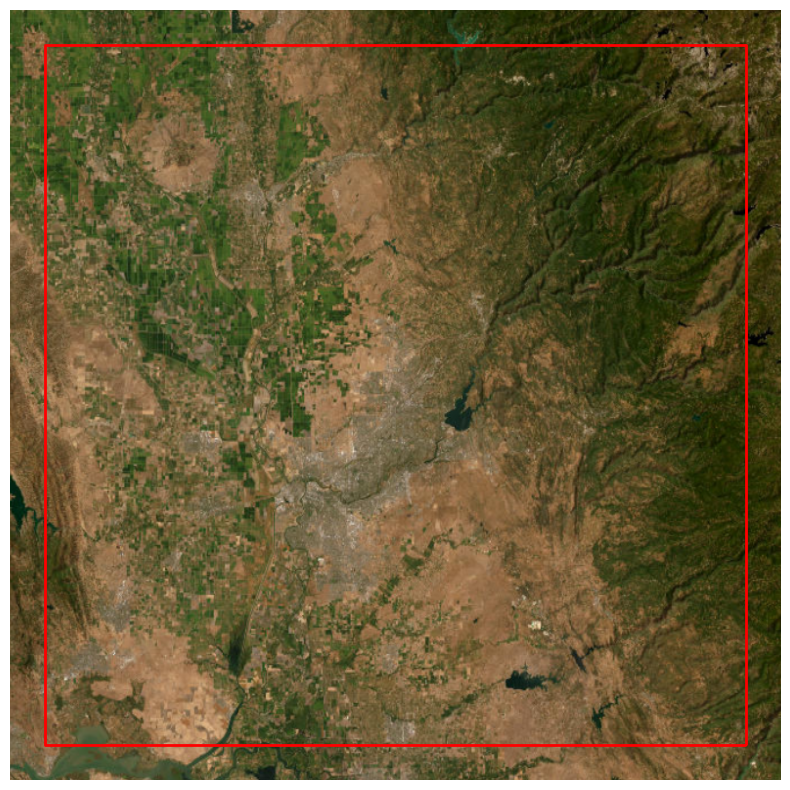

In [114]:
#make a picture from the sacramento bounds
sac_bounds = [min(sacData['Longitude']), min(sacData['Latitude']), max(sacData['Longitude']),max(sacData['Latitude'])]

# get image and other stuff
#get a geoDataFrame for the data and view it
sac_gdf = gpd.GeoDataFrame(
    {"geometry": [box(*sac_bounds)]}, 
    crs="EPSG:4326"  # Latitude/Longitude Coordinate System
)

sac_gdf = sac_gdf.to_crs(epsg=4326)

# Plot with correct projection
figS, axS = plt.subplots(figsize=(10, 10))
sac_gdf.plot(ax=axS, facecolor="none", edgecolor="red", linewidth=2)

# Add basemap with the correct CRS
ctx.add_basemap(axS, source=ctx.providers.Esri.WorldImagery, crs=sac_gdf.crs, attribution=False)

# Label axes with lat/lon
axS.set_xlabel("Longitude")
axS.set_ylabel("Latitude")

#save this image of bronx for further anlysis:
plt.axis("off")
plt.savefig("sacramento_map.png", dpi=300, bbox_inches='tight')

plt.show() #just the plot should have the lat and lon values


In [116]:
#above image is vegetation heavy and on a different coast so will put model to the test:
image_arrayS = mpimg.imread("sacramento_map.png")
xlimS = axS.get_xlim()  # (min_lon, max_lon)
ylimS = axS.get_ylim()  # (min_lat, max_lat)

img_heightS, img_widthS = image_arrayS.shape[:2]


sacData["Pixel_X"], sacData["Pixel_Y"] = zip(*sacData.apply(lambda row: latlon_to_pixel(
    row["Longitude"], row["Latitude"], xlimS, ylimS, img_widthS, img_heightS), axis=1))

pixel_pairsS = list(zip(sacData["Pixel_X"], sacData["Pixel_Y"]))

rgb_valuesS = [image_arrayS[y, x] for x, y in pixel_pairsS]
uhi_ListS = np.array(sacData['UHI_Index'])


In [117]:
rgbsS = np.array(rgb_valuesS)
#print(rgb_values)
dataS = torch.tensor(rgbsS.reshape(-1,4), dtype=torch.float32)
targetsS =torch.tensor(uhi_ListS.reshape(-1,1),dtype=torch.float32)


In [118]:
#try eval on model
with torch.no_grad():  # Disable gradient computation for testing
    nn_model1.eval()  # Set the model to evaluation mode
    val_preds = nn_model1(dataS)  # Get predictions on the validation set
    val_loss = criterion(val_preds, targetsS)  # Calculate loss
    print(f'Validation Loss: {val_loss.item():.4f}')

Validation Loss: 0.0086


In [ ]:
#the model knows vegetation well, going to transfer it and functionalize it in a different 
#for now, we will create the submission csv

#load the submission csv
submissionData=pd.read_csv('Submission_template.csv')
#separate it into sub manhattan and sub bronx
manSubData = submissionData[(submissionData['Latitude'] >= manhattan_bounds[1]) & 
                 (submissionData['Latitude'] <= manhattan_bounds[3]) & 
                 (submissionData['Longitude'] >= manhattan_bounds[0]) & 
                 (submissionData['Longitude'] <= manhattan_bounds[2])]

bronxSubData = submissionData[~submissionData.isin(manSubData.to_dict(orient='list')).all(axis=1)]




,Longitude,Latitude,UHI Index,Pixel_X,Pixel_Y
63,-73.892860,40.841388,NaN,1182,735
66,-73.898815,40.807217,NaN,1004,2066
87,-73.924488,40.843607,NaN,239,648
88,-73.898947,40.807843,NaN,1000,2042
104,-73.894062,40.842092,NaN,1146,707


In [121]:
manSubData["Pixel_X"], manSubData["Pixel_Y"] = zip(*manSubData.apply(lambda row: latlon_to_pixel(
    row["Longitude"], row["Latitude"], xlim, ylim, img_width, img_height), axis=1))

pixel_pairsMS = list(zip(manSubData["Pixel_X"], manSubData["Pixel_Y"]))

rgb_valuesMS = [image_array[y, x] for x, y in pixel_pairsMS]
#uhi_ListS = np.array(sacData['UHI Index'])

rgbsMS = np.array(rgb_valuesMS)
#print(rgb_values)
dataMS = torch.tensor(rgbsMS.reshape(-1,4), dtype=torch.float32)
targetsMS =torch.tensor(uhi_ListS.reshape(-1,1),dtype=torch.float32)

/tmp/ipykernel_242639/1290261554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manSubData["Pixel_X"], manSubData["Pixel_Y"] = zip(*manSubData.apply(lambda row: latlon_to_pixel(
/tmp/ipykernel_242639/1290261554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manSubData["Pixel_X"], manSubData["Pixel_Y"] = zip(*manSubData.apply(lambda row: latlon_to_pixel(


In [123]:
bronxSubData["Pixel_X"], bronxSubData["Pixel_Y"] = zip(*bronxSubData.apply(lambda row: latlon_to_pixel(
    row["Longitude"], row["Latitude"], xlimB, ylimB, img_widthB, img_heightB), axis=1))

pixel_pairsBS = list(zip(bronxSubData["Pixel_X"], bronxSubData["Pixel_Y"]))

rgb_valuesBS = [image_arrayB[y, x] for x, y in pixel_pairsBS]
#uhi_ListS = np.array(sacData['UHI Index'])

rgbsBS = np.array(rgb_valuesBS)
#print(rgb_values)
dataBS = torch.tensor(rgbsBS.reshape(-1,4), dtype=torch.float32)
targetsBS =torch.tensor(uhi_ListS.reshape(-1,1),dtype=torch.float32)

/tmp/ipykernel_242639/1596080671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bronxSubData["Pixel_X"], bronxSubData["Pixel_Y"] = zip(*bronxSubData.apply(lambda row: latlon_to_pixel(


In [ ]:
#first we need to view the outputs of the model
manhattan_predictions=nn_model1(dataMS).detach().numpy().flatten()
bronx_predictions=nn_model1(dataB).detach().numpy().flatten()
#essentially I want to attach these back to their lats and lons ASK CHAT


In [ ]:
lat_lon_pairs = []

for pred in manhattan_predictions:
    = zip(*manTrainData.apply(lambda row: pixel_to_latlon(
    row["Longitude"], row["Latitude"], xlim, ylim, img_width, img_height), axis=1))
#now convert pixels back to lat/lon and match them with the submission file
 = zip(*manTrainData.apply(lambda row: pixel_to_latlon(
    row["Longitude"], row["Latitude"], xlim, ylim, img_width, img_height), axis=1))

# Convert to a list of (x, y) pixel pairs
pixel_pairs = list(zip(manTrainData["Pixel_X"], manTrainData["Pixel_Y"]))



558